In [1]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
# import seaborn as sns

# from nba_utils import draw_3pt_piechart,plot_shot_chart

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import colorbar as cbar
from matplotlib import cbook as cbook
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf
from pyspark.sql.functions import year, month, dayofmonth, hour, minute
from pyspark.sql.types import *

import warnings
warnings.filterwarnings("ignore")

# sns.set_style("white")
# sns.set_color_codes()

In [2]:
customSchema = StructType([ 
    StructField("IncidntNum", StringType(), True), 
    StructField("Category", StringType(), True), 
    StructField("Description", StringType(), True), 
    StructField("DayOfWeek", StringType(), True), 
    StructField("Date_str", StringType(), True), 
    StructField("Time_str", StringType(), True), 
    StructField("District", StringType(), True), 
    StructField("Resolution", StringType(), True), 
    StructField("Address", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("PdId", StringType(), True), ])

In [3]:
crimeDFsource = spark.read.csv('s3a://davidsx/dataSFcrime/', header=True, schema = customSchema)

In [4]:
from pyspark.sql.functions import to_timestamp, concat_ws

crimeDF = crimeDFsource.withColumn("DateTime_str", concat_ws(' ',crimeDFsource.Date_str,crimeDFsource.Time_str))\
.withColumn('Datetime',to_timestamp('DateTime_str', 'MM/dd/yyyy HH:mm').cast(TimestampType()))\

crimeDF = crimeDF.withColumn("Year", year("Datetime")).withColumn("Month", month("Datetime"))\
.withColumn("DayOfMonth",dayofmonth("Datetime")).withColumn("Hour", hour("Datetime"))\
.withColumn("Minute", minute("Datetime"))

crimeDF = crimeDF.drop('Date_str','Time_str','DateTime_str','Resolution','Location','PdId')
crimeDF.printSchema()

root
 |-- IncidntNum: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Datetime: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)



In [5]:
crimeDF.cache()
sqlContext.registerDataFrameAsTable(crimeDF, 'df')

In [24]:
hourly_count = crimeDF.where(col('Hour').isNotNull()).groupBy('Hour').count().orderBy('Hour')
month_count = crimeDF.where(col('Month').isNotNull()).groupBy('Month').count().orderBy('Month')
day_month_count = crimeDF.where((col('DayOfMonth').isNotNull())&col('Month').isNotNull())\
                        .groupBy('DayOfMonth','Month').count().orderBy('Month','DayOfMonth')
year_count = crimeDF.where(col('Year')!=2018).where(col('Year').isNotNull()).groupBy('Year').count().orderBy('Year')

In [19]:
sqlContext.registerDataFrameAsTable(day_month_count, 'dm')
# sqlContext.sql('SELECT * from dm \
#                where DayOfMonth!=29 and Month!=2').show(n=366)

+----------+-----+-----+
|DayOfMonth|Month|count|
+----------+-----+-----+
|         1|    1| 8869|
|         2|    1| 5744|
|         3|    1| 6017|
|         4|    1| 5891|
|         5|    1| 6299|
|         6|    1| 6359|
|         7|    1| 6325|
|         8|    1| 6116|
|         9|    1| 6239|
|        10|    1| 6406|
|        11|    1| 6088|
|        12|    1| 6384|
|        13|    1| 6493|
|        14|    1| 6466|
|        15|    1| 6627|
|        16|    1| 6353|
|        17|    1| 6258|
|        18|    1| 6178|
|        19|    1| 6352|
|        20|    1| 6350|
|        21|    1| 6270|
|        22|    1| 6370|
|        23|    1| 6472|
|        24|    1| 6303|
|        25|    1| 6484|
|        26|    1| 6226|
|        27|    1| 6513|
|        28|    1| 6284|
|        30|    1| 6155|
|        31|    1| 6259|
|         1|    3| 7374|
|         2|    3| 6303|
|         3|    3| 6452|
|         4|    3| 6487|
|         5|    3| 6349|
|         6|    3| 6204|
|         7|    3| 6284|


In [8]:
month_count.show()

+-----+------+
|Month| count|
+-----+------+
|    1|197584|
|    2|178619|
|    3|197580|
|    4|189834|
|    5|187747|
|    6|174743|
|    7|181822|
|    8|187379|
|    9|183437|
|   10|190470|
|   11|175031|
|   12|170776|
+-----+------+



In [29]:
hourly_count_list = hourly_count.rdd.map(lambda x : x[1]).collect()
hour = np.arange(24)
high_time_count = hourly_count.agg({'count':'max'}).rdd.map(lambda x : x[0]).collect()[0]
high_time = hourly_count.where(col('count') == high_time_count).rdd.map(lambda x : x[0]).collect()[0]

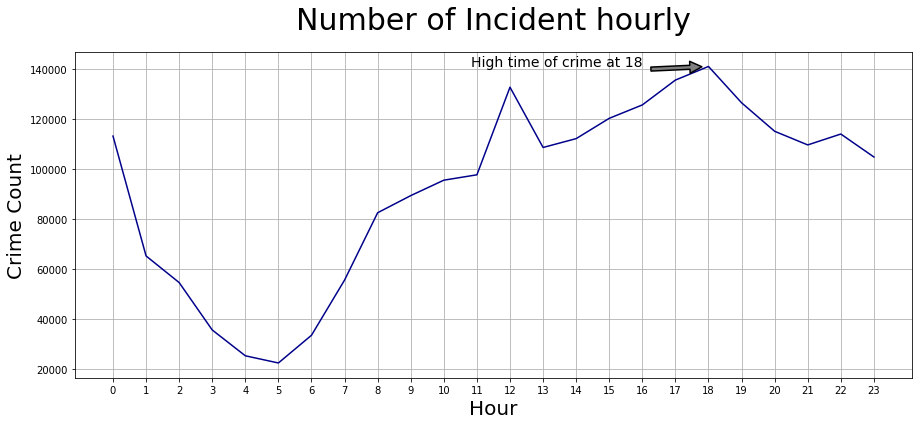

In [10]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(111)
ax.set_xticks(hour)
ax.set_ylabel("Crime Count",size="20")
ax.set_xlabel('Hour',size="20")
ax.set_title('Number of Incident hourly', size=30, y=1.05)
ax.grid()
ax.annotate('High time of crime at {}'.format(high_time), xy=(high_time, high_time_count), 
            xytext=(high_time - 2, high_time_count - .75), fontsize = 14, horizontalalignment='right',
            arrowprops=dict(facecolor='grey', shrink=0.1, linewidth = 1.5))

ax.plot(hour,hourly_count_list, color = 'darkBlue')

In [25]:
year_count_list = year_count.rdd.map(lambda x : x[1]).collect()
year = np.arange(len(year_count_list))
years = year_count.rdd.map(lambda x : x[0]).collect()

<BarContainer object of 15 artists>

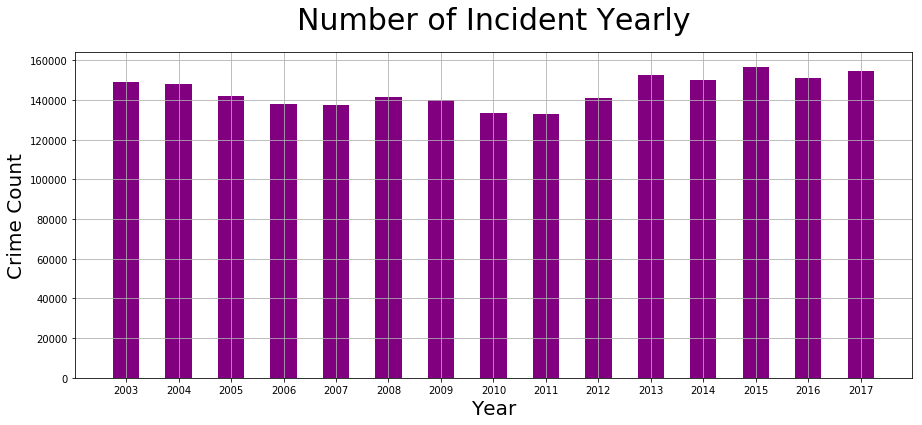

In [42]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(111)
ax.set_xticks(year)
ax.set_ylabel("Crime Count",size="20")
ax.set_xlabel('Year',size="20")
ax.set_xticklabels(years)
ax.set_title('Number of Incident Yearly', size=30, y=1.05)
ax.grid()
# ax.annotate('High time of crime!', xy=(high_time, high_time_count), 
#             xytext=(high_time - 2, high_time_count - .75), fontsize = 14, horizontalalignment='right',
#             arrowprops=dict(facecolor='grey', shrink=0.1, linewidth = 1.5))

ax.bar(year,year_count_list, color = 'purple', width=0.5)

In [44]:
month_count_list = month_count.rdd.map(lambda x : x[1]).collect()
month = np.arange(12)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

<BarContainer object of 12 artists>

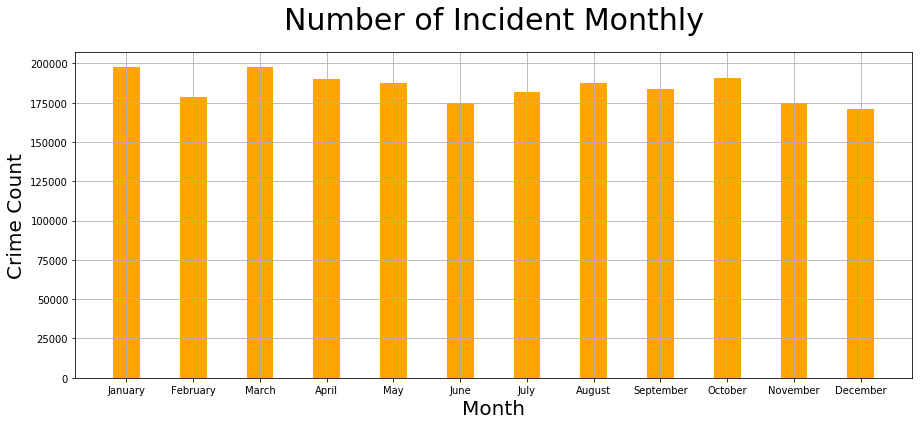

In [54]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(111)
ax.set_xticks(month)
ax.set_ylabel("Crime Count",size="20")
ax.set_xlabel('Month',size="20")
ax.set_xticklabels(months)
ax.set_title('Number of Incident Monthly', size=30, y=1.05)
ax.grid()
# ax.annotate('High time of crime!', xy=(high_time, high_time_count), 
#             xytext=(high_time - 2, high_time_count - .75), fontsize = 14, horizontalalignment='right',
#             arrowprops=dict(facecolor='grey', shrink=0.1, linewidth = 1.5))

ax.bar(month,month_count_list, color = 'orange', width=0.4)

In [47]:
day_month_count_list = day_month_count.rdd.map(lambda x : x[2]).collect()
day_month = np.arange(366)

In [48]:
from datetime import timedelta, date
dtl = [1] * 366

start_dt = date(2017, 1, 1)
end_dt = date(2017, 2, 28)
dtrange = int ((end_dt - start_dt).days)+1
for n in range(dtrange):
    dt = start_dt + timedelta(n)
    dtl[n] = dt.strftime("%m/%d")
    
dtl[dtrange] = '02/29'

start_dt = date(2017, 3, 1)
end_dt = date(2017, 12, 31)
old_range = dtrange
dtrange = int ((end_dt - start_dt).days)+1
for n in range(dtrange):
    dt = start_dt + timedelta(n)
    dtl[n+old_range+1] = dt.strftime("%m/%d")

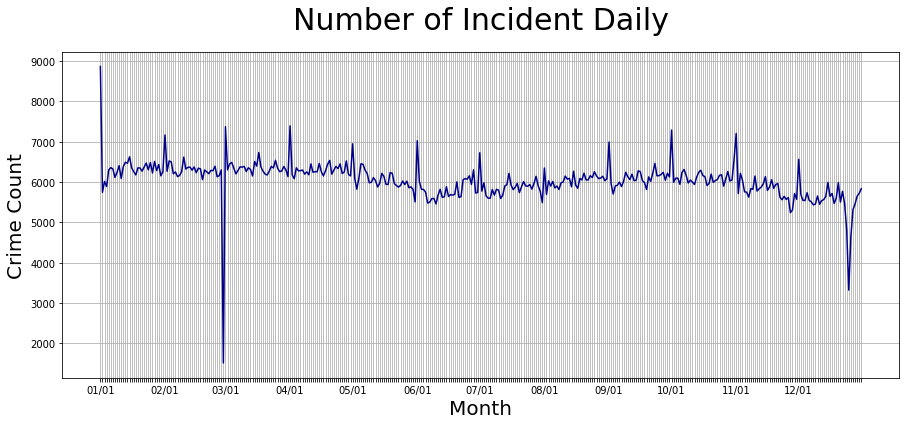

In [49]:
fig = plt.figure(figsize=(15,6))
day_month = np.arange(366)
ax = fig.add_subplot(111)
ax.set_xticks(np.arange(366))
ax.set_ylabel("Crime Count",size="20")
ax.set_xlabel('Month',size="20")
ax.set_xticklabels(dtl)
ax.set_title('Number of Incident Daily', size=30, y=1.05)
ax.grid()
for index, label in enumerate(ax.xaxis.get_ticklabels()):
#     print(index)
    if dtl[index][3:] != '01':
        label.set_visible(False)
# ax.annotate('High time of crime!', xy=(high_time, high_time_count), 
#             xytext=(high_time - 2, high_time_count - .75), fontsize = 14, horizontalalignment='right',
#             arrowprops=dict(facecolor='grey', shrink=0.1, linewidth = 1.5))

ax.plot(day_month,day_month_count_list, color = 'darkBlue')

In [ ]:
crimeDF.groupBy('Year','Month').count().show()

In [44]:
month_count_list = month_count.rdd.map(lambda x : x[1]).collect()
month = np.arange(12)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

<BarContainer object of 12 artists>

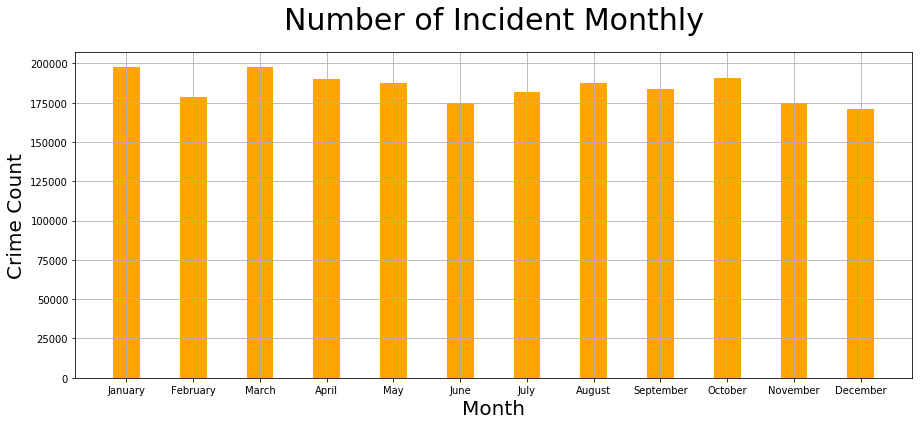

In [54]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(111)
ax.set_xticks(month)
ax.set_ylabel("Crime Count",size="20")
ax.set_xlabel('Month',size="20")
ax.set_xticklabels(months)
ax.set_title('Number of Incident Monthly', size=30, y=1.05)
ax.grid()
# ax.annotate('High time of crime!', xy=(high_time, high_time_count), 
#             xytext=(high_time - 2, high_time_count - .75), fontsize = 14, horizontalalignment='right',
#             arrowprops=dict(facecolor='grey', shrink=0.1, linewidth = 1.5))

ax.bar(month,month_count_list, color = 'orange', width=0.4)